# Qibolab v0.1.6 1Q emulator demo for QuTiP engine

Results updated on: 11 May 2024

## Example 0: Emulator Setup

In [1]:
# add directory of emulator platform to QIBOLAB_PLATFORMS environment variable
import pathlib, os
emulator_path = pathlib.Path(os.path.abspath('')).parent/'tests/emulators/'
os.environ["QIBOLAB_PLATFORMS"] = emulator_path.as_posix() 

# create emulator platform as per any other platforms
from qibolab import create_platform
emulator_platform = create_platform("default_q0")
pulse_simulator = emulator_platform.instruments['pulse_simulator']
simulation_engine = pulse_simulator.simulation_engine

# import visualization tools
from qibolab_visualization.emulator import print_hamiltonian, plot_fidelities #plot_fidelity_history

INFO:root:ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine
INFO:root:emulator qubits: ['0']
INFO:root:emulator couplers: []
INFO:root:runcard qubits: [0]
INFO:root:runcard couplers: []
INFO:root:sampling rate: 4.5GHz
INFO:root:simulation sampling boost: 10
[Qibo 0.2.6|INFO|2024-05-12 00:36:38]: Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine
INFO:qibo.config:Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine


Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]


In [2]:
print_hamiltonian(simulation_engine.model_config)

Dictionary


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



---------------------
One-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drift terms:
---------------------
None
---------------------
One-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Dissipative terms:
---------------------
>> t1 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

>> t2 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------


## Example 1: Simulation of Pulse Sequence

### Preparation: Construct Pulse Sequence

PulseSequence
DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)
ReadoutPulse(37.77777777777778, 4977.777777777777, 0.03, 7_301_661_824.000001, 0, Rectangular(), readout-0, 0)


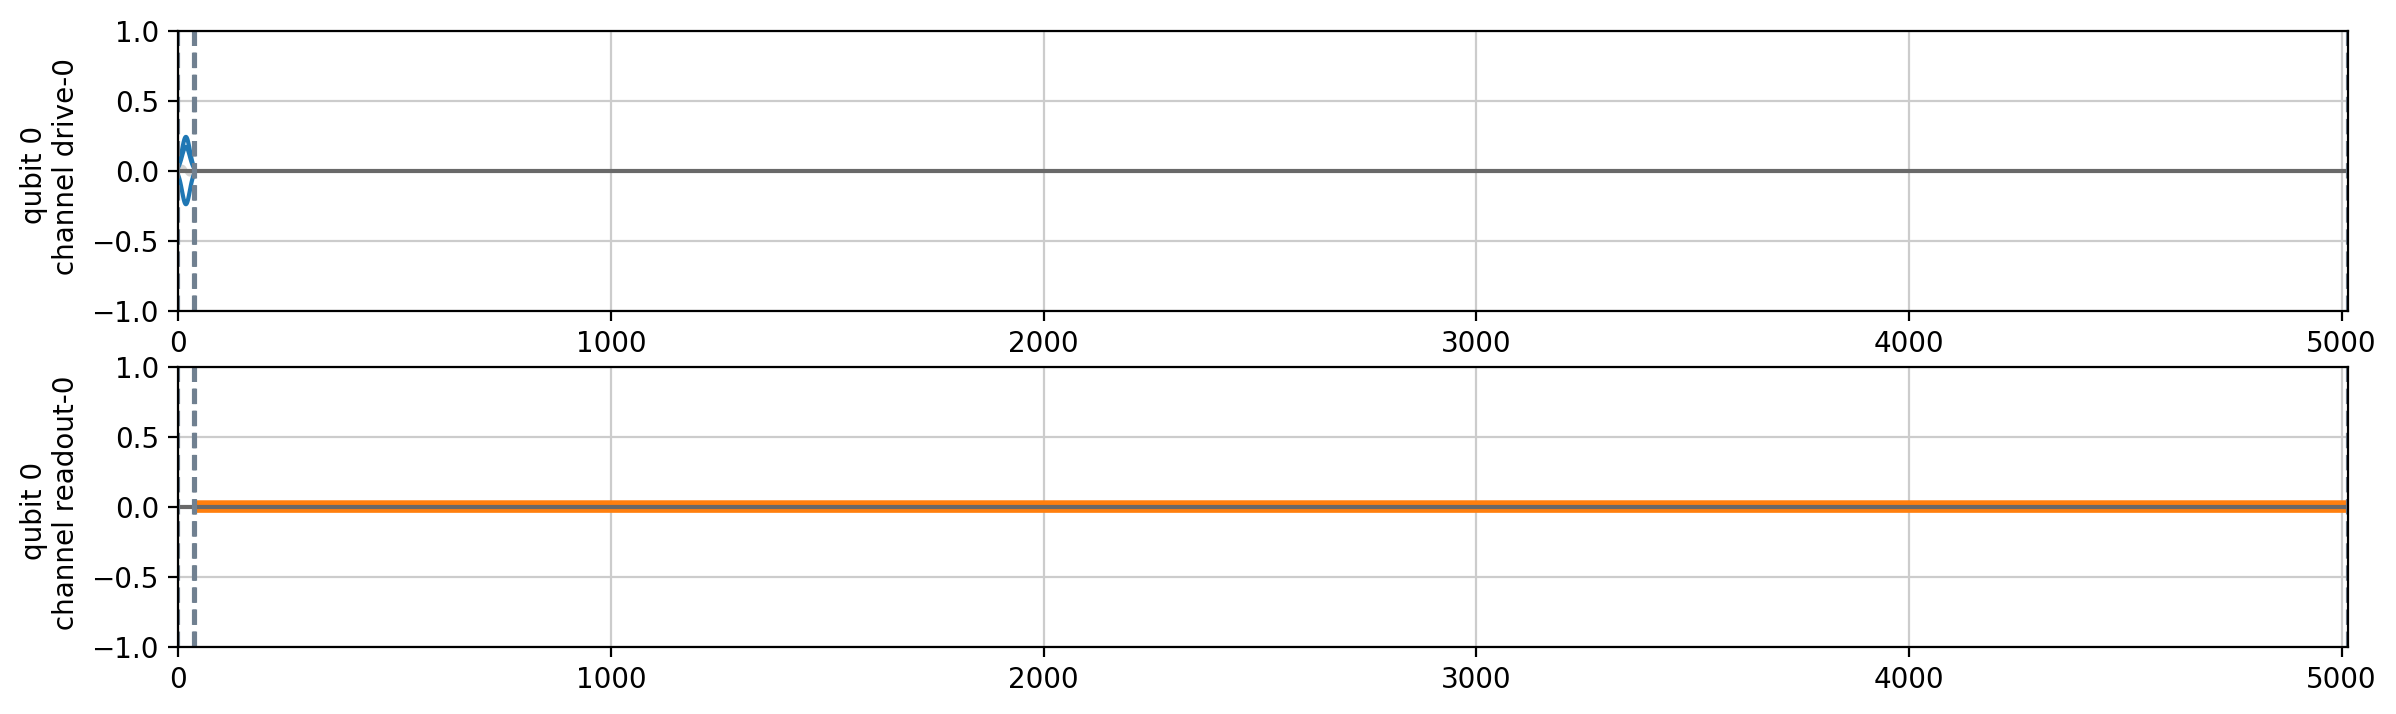

5015.555555555555
37.77777777777778
4977.777777777777


In [3]:
from qibolab.pulses import (
    DrivePulse,
    ReadoutPulse,
    PulseSequence,
    Rectangular,
    Gaussian,
    Drag
)

# Define PulseSequence
sequence = PulseSequence()

# Add some pulses to the pulse sequence
'''
pulse_x0 = DrivePulse(
    start=0,
    frequency=5_090_167_234.445013,
    amplitude=0.240451, 
    duration=35.55555555555556, 
    relative_phase=0,
    shape=Drag(4, 2.43058),
    channel='drive-0',
    qubit=0,
    )
    
pulse_r0 = ReadoutPulse(
    start=10/4.5+x0_pulse.duration,
    frequency=1_622_591_516, 
    amplitude=0.03, 
    duration=10/4.5,
    relative_phase=0,
    shape=Rectangular(),
    channel='readout-0',
    qubit=0,
    )
'''
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(170/4.5))

sequence = PulseSequence()
sequence.add(pulse_x0)
sequence.add(pulse_r0)

print(sequence)
sequence.plot()
print(sequence.duration)
print(pulse_r0.start)
print(pulse_r0.duration)

### Execution: Emulator Pulse and Generate Pulse Sequence

In [4]:
from qibolab.execution_parameters import ExecutionParameters

# Connects to lab instruments using the details specified in the calibration settings.
emulator_platform.instruments['pulse_simulator'].connect()

# Configures instruments using the loaded calibration settings.
emulator_platform.instruments['pulse_simulator'].setup()

# Turn off readout error
emulator_platform.instruments['pulse_simulator'].readout_error = None

# Executes a pulse sequence.
options = ExecutionParameters(nshots=1000)#, relaxation_time=100)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)
#results = pulse_simulator.play({0:0}, {}, sequence, options=options)

# Disconnect from the instruments
emulator_platform.instruments['pulse_simulator'].disconnect()

[Qibo 0.2.6|INFO|2024-05-12 00:36:39]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-12 00:36:39]: Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-12 00:36:39]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 Total run time:   1.46s*] Elapsed 1.46s / Remaining 00:00:00:00
simulation time 1.5082738329999996


[Qibo 0.2.6|INFO|2024-05-12 00:36:40]: Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.


In [5]:
simulated_states = results['simulation']['output_states']
final_state = simulated_states[-1]
final_state

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 9.12786064e-02+3.75507569e-16j -2.17612663e-01-1.85938657e-01j
  -1.15858173e-03-1.63811697e-03j]
 [-2.17612663e-01+1.85938657e-01j  9.08676353e-01-3.78508780e-16j
   6.17322451e-03+1.56422765e-03j]
 [-1.15858173e-03+1.63811697e-03j  6.17322451e-03-1.56422765e-03j
   4.50402806e-05+3.00161782e-18j]]

In [6]:
print(f'final state norm: {final_state.norm()}')

final state norm: 1.0000000000000082


In [7]:
results[list(results.keys())[1]].samples

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

In [51]:
# Generate time list
sequence_duration = results['simulation']['sequence_duration']
simulation_dt = results['simulation']['simulation_dt']
simulation_time = results['simulation']['simulation_time']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_81683/2963860698.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fidelities = simulation_engine.compute_fidelities(simulated_states)


[0] 0.3021234952198591
[1] 0.9532451695946323
[2] 0.006711205603255944


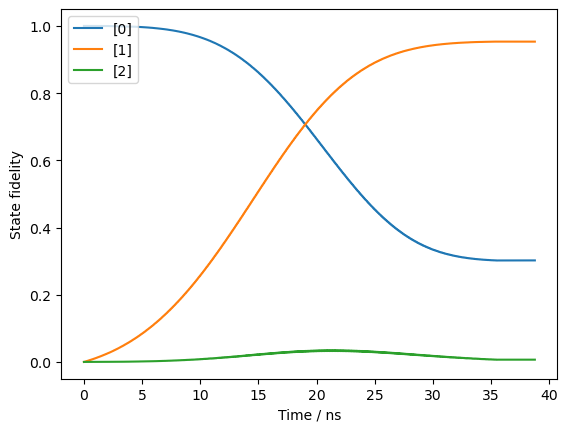

In [53]:
fidelities = simulation_engine.compute_fidelities(simulated_states)
plot_fidelities(fidelities,sim_time_list,time_label='Time / ns');

### Print out the Pulse Sequence

In [13]:
from qibolab.instruments.emulator.pulse_simulator import ps_to_waveform_dict, truncate_ro_pulses
pulse_simulator = emulator_platform.instruments['pulse_simulator']
channel_waveforms = ps_to_waveform_dict(
            truncate_ro_pulses(sequence),
            pulse_simulator.platform_to_simulator_channels,
            pulse_simulator.sampling_rate,
            pulse_simulator.sim_sampling_boost,
            pulse_simulator.runcard_duration_in_dt_units,
        )

### Plot the Simulated Waveform

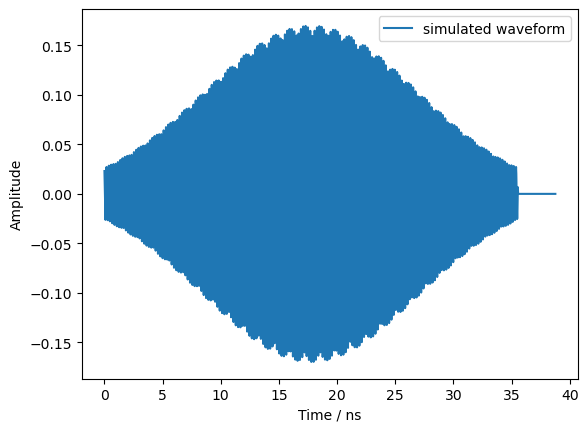

In [14]:
import matplotlib.pyplot as plt
plt.plot(channel_waveforms['time'],channel_waveforms['channels']['D-0'], label='simulated waveform')
plt.xlabel('Time / ns')
plt.ylabel('Amplitude')
plt.legend()

### Perform sampling and apply readout noise

In [15]:
from qibolab.instruments.emulator.pulse_simulator import get_samples

ro_qubit_list = [pulse_r0.qubit]
ro_reduced_dm, rdm_qubit_list = pulse_simulator.simulation_engine.qobj_to_reduced_dm(final_state, ro_qubit_list)
samples = get_samples(1000, ro_reduced_dm, rdm_qubit_list, pulse_simulator.simulation_engine.qid_nlevels_map)

In [16]:
import numpy as np
from qibolab.instruments.emulator.pulse_simulator import apply_readout_noise

readout_error = {0: [0.1, 0.1], 1: [0.1, 0.1]}
noisy_samples = apply_readout_noise(samples, readout_error)
print('samples without noise: ', samples[0][:20], np.sum(noisy_samples[0]))
print('samples with noise:    ', noisy_samples[0][:20], np.sum(samples[0]))

samples without noise:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0] 854
samples with noise:     [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0] 916


## Example 2. Pulse-level Simulation of X0 Gate

### Preparation: 1. Construct qibolab backend with transpiler settings

In [17]:
# reset pulse simulator; resets readout_error to model_config values
pulse_simulator.update()
simulation_engine = pulse_simulator.simulation_engine
print('readout error: ',emulator_platform.instruments['pulse_simulator'].readout_error)
print('pulse sequence history: ', emulator_platform.instruments['pulse_simulator'].pulse_sequence_history)
print('pulse sequences simulated: ', len(emulator_platform.instruments['pulse_simulator'].simulation_engine.pulse_sim_history))

# option 1, using default transpiler
from qibolab.backends import QibolabBackend
from qibo.transpiler.pipeline import Passes

emulator_backend = QibolabBackend(platform=emulator_platform)
emulator_backend.transpiler = Passes(connectivity=emulator_backend.platform.topology)
emulator_backend.transpiler.passes = list(emulator_backend.transpiler.passes[i] for i in [0,1,3])
emulator_backend.transpiler.passes

Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]
readout error:  {0: [0.01, 0.02]}
pulse sequence history:  []
pulse sequences simulated:  0


In [18]:
zerostate = simulation_engine.psi0.copy()

### Preparation: 2. Prepare test state - X0 gate

In [19]:
from qutip import Qobj
import numpy as np

# prepare test state
qibo_statevector = np.array([0.,1.])
sim_statevector = np.array([0.,1.,0.])
teststate = simulation_engine.make_arbitrary_state(sim_statevector)

# initialize with |00> state
#simulation_engine.psi0 = zerostate
# initialize with test state
simulation_engine.psi0 = teststate

print("qibo test statevector", qibo_statevector)
print(simulation_engine.psi0)

qibo test statevector [0. 1.]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]


### Preparation: 3. Construct the Circuit

In [20]:
from qibo.models import Circuit
from qibo import gates

circ_x0 = Circuit(1)
circ_x0.add(gates.X(0))
circ_x0.add(gates.M(*range(1)))
#circ_x0_job = circ_x0(nshots=1000)
circ_x0_job = circ_x0(qibo_statevector,nshots=1000)
ideal_x0_results = circ_x0_job.frequencies()

print(circ_x0.draw())
print(ideal_x0_results)
circ_x0_job.state()

[Qibo 0.2.6|INFO|2024-05-12 00:36:42]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


q0: ─X─M─
Counter({'0': 1000})


array([1.+0.j, 0.+0.j])

### Execution: Perform Pulse-level Simulation of the X0 Gate

In [21]:
#x0
backend_job = emulator_backend.execute_circuit(circ_x0, nshots=1000)

[Qibo 0.2.6|ERROR|2024-05-12 00:36:42]: x is not a native gate.
ERROR:qibo.config:x is not a native gate.
[Qibo 0.2.6|INFO|2024-05-12 00:36:42]: Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x1414528e0>.
INFO:qibo.config:Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x1414528e0>.
[Qibo 0.2.6|INFO|2024-05-12 00:36:42]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-12 00:36:42]: Minimal execution time (sequence): 0.3050488888888889
INFO:qibo.config:Minimal execution time (sequence): 0.3050488888888889


 [*********85%********   ] Elapsed 2.13s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
backend_job.frequencies()

Counter({'0': 937, '1': 63})

## Example 3: Sweeper

### Preparation: Construct Reference Pulse Sequence

Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]
readout error:  {0: [0.01, 0.02]}
pulse sequence history:  []
pulse sequences simulated:  0


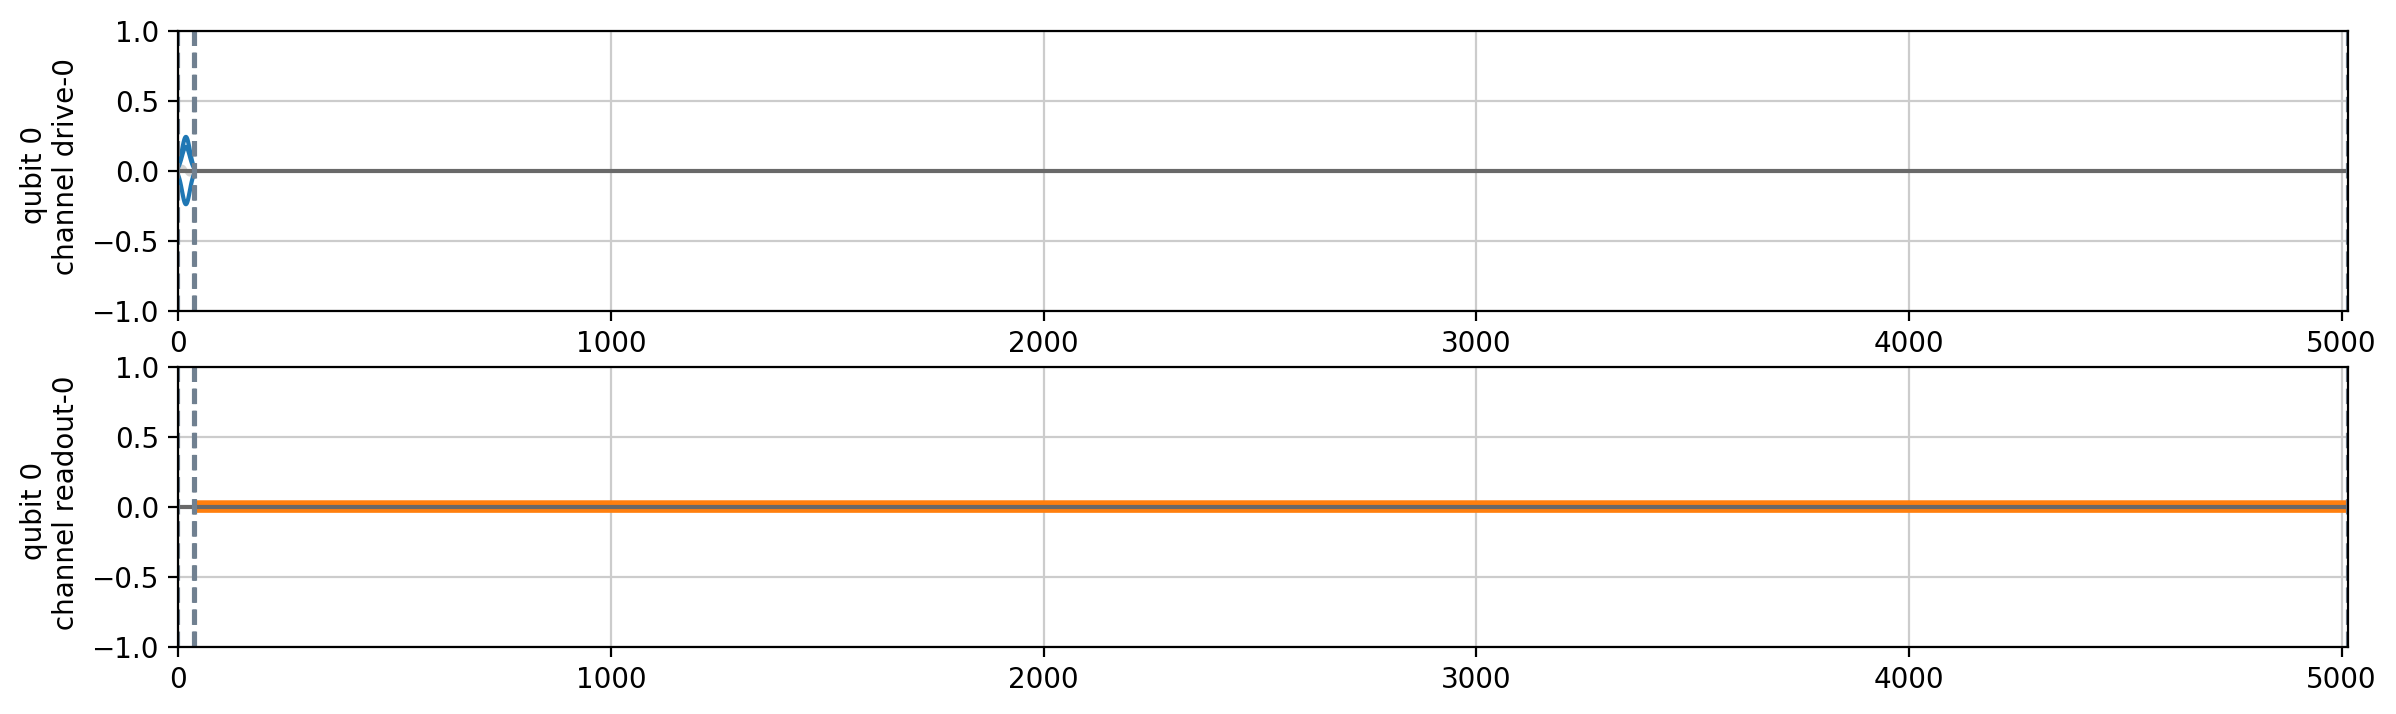

5015.555555555555
38.666666666666664
4977.777777777777


In [23]:
import numpy as np
from qibolab.pulses import PulseSequence
from qibolab import ExecutionParameters

# reset pulse simulator
pulse_simulator.update()
simulation_engine = pulse_simulator.simulation_engine
print('readout error: ',emulator_platform.instruments['pulse_simulator'].readout_error)
print('pulse sequence history: ', emulator_platform.instruments['pulse_simulator'].pulse_sequence_history)
print('pulse sequences simulated: ', len(emulator_platform.instruments['pulse_simulator'].simulation_engine.pulse_sim_history))

sequence = PulseSequence()
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
sequence.add(pulse_x0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(165/4.5+5/4.5))
sequence.add(pulse_r0)
sequence.plot()
print(sequence.duration)
print(pulse_r0.start+4/4.5)
print(pulse_r0.duration)

### Check: Simulate Reference Pulse Sequence

In [24]:
from qibolab.execution_parameters import ExecutionParameters

# Connects to lab instruments using the details specified in the calibration settings.
emulator_platform.instruments['pulse_simulator'].connect()

# Configures instruments using the loaded calibration settings.
emulator_platform.instruments['pulse_simulator'].setup()

# Executes a pulse sequence.
options = ExecutionParameters(nshots=1000)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)

# Disconnect from the instruments
emulator_platform.instruments['pulse_simulator'].disconnect()

[Qibo 0.2.6|INFO|2024-05-12 00:36:45]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-12 00:36:45]: Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-12 00:36:45]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 Total run time:   1.28s*] Elapsed 1.28s / Remaining 00:00:00:00
simulation time 1.286600040999999


[Qibo 0.2.6|INFO|2024-05-12 00:36:46]: Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.


/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_81683/315560334.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fidelities = simulation_engine.compute_fidelities(simulated_states)


[0] 0.3021234952198591
[1] 0.9532451695946323
[2] 0.006711205603255944


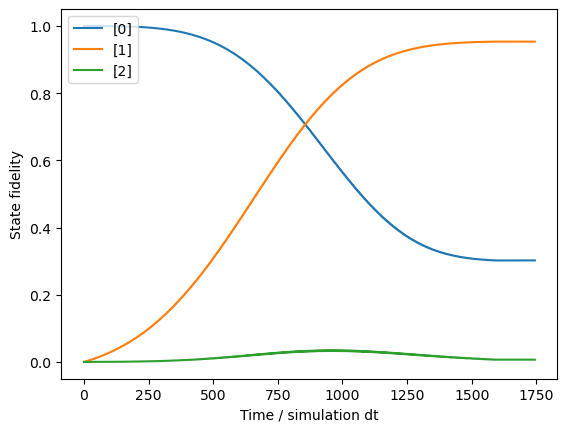

In [25]:
simulated_states = results['simulation']['output_states']
fidelities = simulation_engine.compute_fidelities(simulated_states)
plot_fidelities(fidelities);

In [26]:
from qibolab.sweeper import Sweeper, Parameter

parameter = Parameter.duration
parameter2 = Parameter.amplitude
parameter_range = np.linspace(155/4.5, 165/4.5, num=3)
parameter2_range = np.linspace(0.23045125169257026, 0.25045125169257026, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0])
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0])
'''
parameter_range = np.linspace(-5/4.5, 5/4.5, num=3)
parameter2_range = np.linspace(-0.01, 0.01, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0], type=SweeperType.OFFSET)
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0], type=SweeperType.OFFSET)
'''
print(sweeper)
print(sweeper2)

Sweeper(parameter=<Parameter.duration: 3>, values=array([34.44444444, 35.55555556, 36.66666667]), pulses=[DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)], qubits=None, couplers=None, type=<SweeperType.ABSOLUTE: functools.partial(<function SweeperType.<lambda> at 0x1414474c0>)>)
Sweeper(parameter=<Parameter.amplitude: 2>, values=array([0.23045125, 0.24045125, 0.25045125]), pulses=[DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)], qubits=None, couplers=None, type=<SweeperType.ABSOLUTE: functools.partial(<function SweeperType.<lambda> at 0x1414474c0>)>)


In [27]:
sweep_results = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper)

[Qibo 0.2.6|INFO|2024-05-12 00:36:47]: Minimal execution time (sweep): 3.7480311466666665
INFO:qibo.config:Minimal execution time (sweep): 3.7480311466666665


sweep param: duration
values [34.44444444 35.55555556 36.66666667]
 Total run time:   1.31s*] Elapsed 1.31s / Remaining 00:00:00:00[*********77%******     ] Elapsed 1.07s / Remaining 00:00:00:00
simulation time 1.3107162500000005


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.22s*] Elapsed 1.22s / Remaining 00:00:00:00[*********61%**         ] Elapsed 0.80s / Remaining 00:00:00:00
simulation time 1.2195980410000011
ll 1745


/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_81683/2402698541.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fidelities = simulation_engine.compute_fidelities(state_history)


[0] 0.32627557167174837
[1] 0.9452509665460272
[2] 0.0066978783272993074
[0] 0.3021234952198591
[1] 0.9532451695946323
[2] 0.006711205603255944
[0] 0.28173120510943583
[1] 0.9594725160233565
[2] 0.006326062234328801


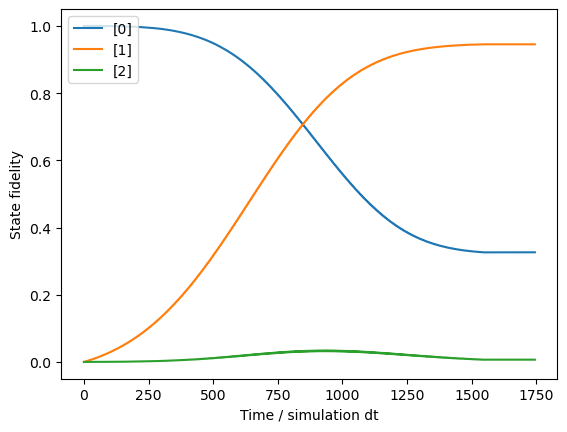

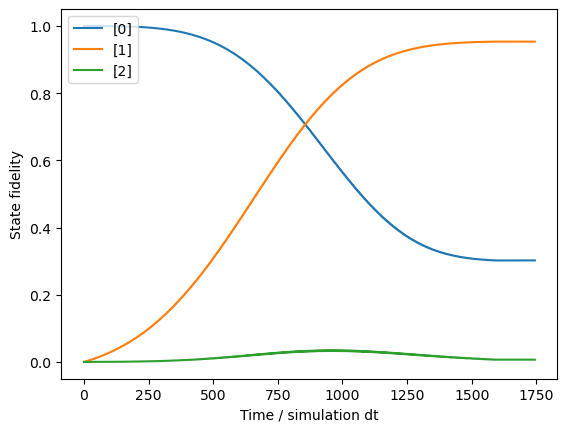

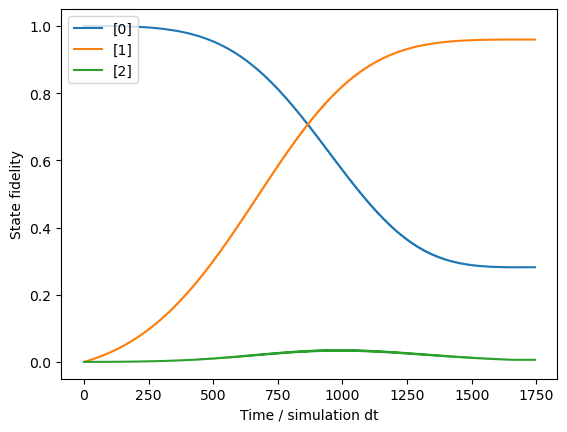

In [28]:
for state_history in sweep_results['simulation']['output_states']:
    fidelities = simulation_engine.compute_fidelities(state_history)
    plot_fidelities(fidelities)

In [29]:
# output only final state
emulator_platform.instruments['pulse_simulator'].output_state_history = False
sweep_results_2 = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper, sweeper2)

[Qibo 0.2.6|INFO|2024-05-12 00:36:56]: Minimal execution time (sweep): 11.24409344
INFO:qibo.config:Minimal execution time (sweep): 11.24409344


sweep param: duration
values [34.44444444 35.55555556 36.66666667]
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.26s*] Elapsed 1.26s / Remaining 00:00:00:00
simulation time 1.2668073750000026
 [*********59%**         ] Elapsed 0.76s / Remaining 00:00:00:00[**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.23s*] Elapsed 1.23s / Remaining 00:00:00:00
simulation time 1.2335881670000006
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.25s*] Elapsed 1.25s / Remaining 00:00:00:00
simulation time 1.256972459
 [******   24%           ] Elapsed 0.37s / Remaining 00:00:00:01[          1%           ] Elapsed 0.01s / Remaining 00:00:00:00[*         6%           ] Elapsed 0.16s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.29s*] Elapsed 1.29s / Remaining 00:00:00:00
simulation time 1.2892227500000004
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.27s*] Elapsed 1.27s / Remaining 00:00:00:00[*********93%*********  ] Elapsed 1.18s / Remaining 00:00:00:00[*********94%********** ] Elapsed 1.19s / Remaining 00:00:00:00[*********94%********** ] Elapsed 1.21s / Remaining 00:00:00:00
simulation time 1.2727271249999994
 Total run time:   1.26s*] Elapsed 1.26s / Remaining 00:00:00:00
simulation time 1.2637969580000004
ll 1


In [30]:
from qibolab.instruments.emulator.pulse_simulator import make_array_index_list

final_states_array = sweep_results_2['simulation']['output_states']
shape = final_states_array.shape
index_list = make_array_index_list(shape)
fidelities = {}
for index in index_list:
    pulse_simulator.merge_sweep_results(fidelities, simulation_engine.compute_fidelities(final_states_array[tuple(index)]))

/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_81683/1114280416.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pulse_simulator.merge_sweep_results(fidelities, simulation_engine.compute_fidelities(final_states_array[tuple(index)]))


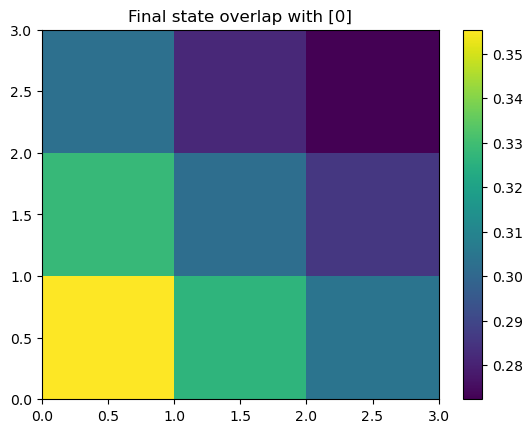

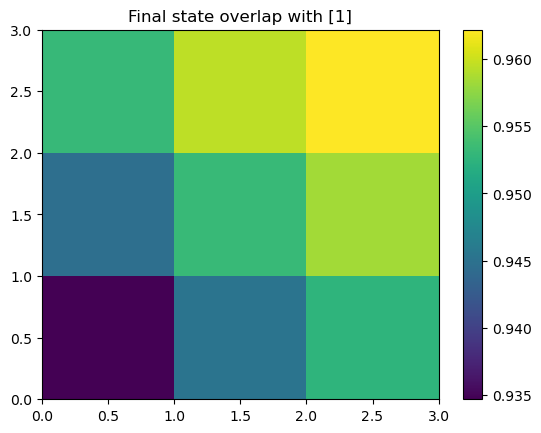

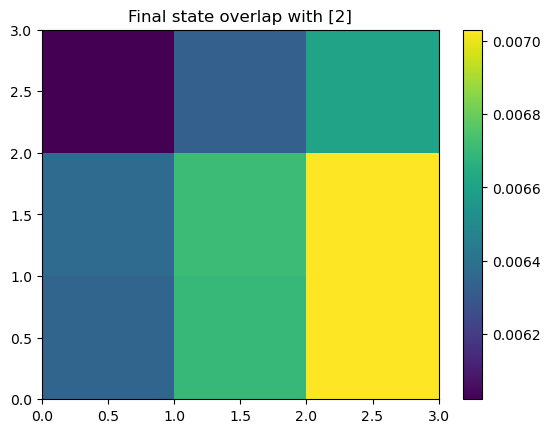

In [31]:
import matplotlib.pyplot as plt
for label in fidelities.keys():
    plt.figure()
    plt.pcolormesh(np.array(fidelities[label]).reshape([3,3]))
    plt.colorbar()
    plt.title(f'Final state overlap with {label}')
    plt.show()

## --- Version information for major packages used in the current Qibolab emulator example ---

In [32]:
%load_ext watermark

In [33]:
%watermark -v -p qibolab,qibo,qutip,matplotlib,numpy

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

qibolab   : 0.1.6
qibo      : 0.2.6
qutip     : 4.7.5
matplotlib: 3.8.0
numpy     : 1.26.4

